# Fraud detection

## Finding people of interest and indicative language, Part 3

### The Enron Corporation

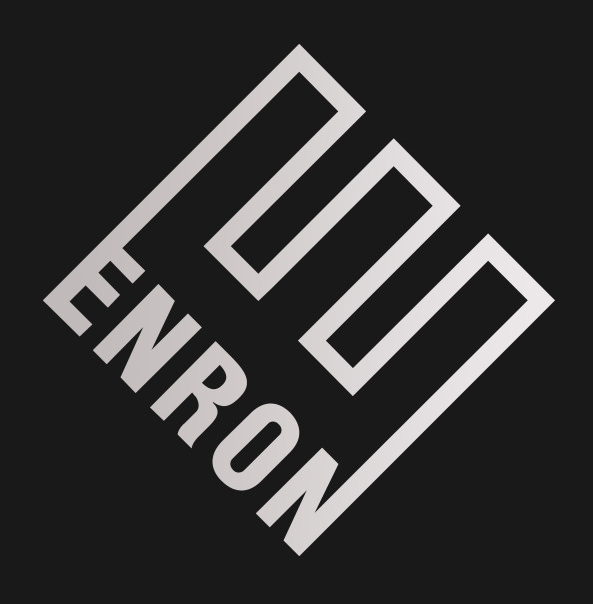


The next few notebooks are broken up to minimize the impact on the computer memory.  The dataset is enormous and breaking it up ensures we are actually able to run the code.

As with any notebook we must begin by importing the libraries we'll need.

In [1]:
import pandas as pd
import numpy as np
import string
from operator import itemgetter
from datetime import datetime
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.classify import maxent
from nltk.probability import FreqDist
from nltk.tree import Tree
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

We can also call up all the variables that we saved before so we have them for use in this notebook.

In [2]:
%store -r km_text

In [3]:
%store -r useful_words

In [4]:
%store -r frequency

In [5]:
%store -r result

In [6]:
%store -r most_frequent

In [7]:
%store -r top_words

Before we get too deep into the exploration and prep here, let's get an idea of the dimensionality of the data set.  

In [8]:
fdistkm = FreqDist(useful_words)
fdistall = FreqDist(most_frequent)
print(fdistkm.N())
print(fdistall.N())

7729458
57067704


WOW! 16 million words in just one person's written emails!  And over 144 million in the whole dataset.  

That is a lot of words.  

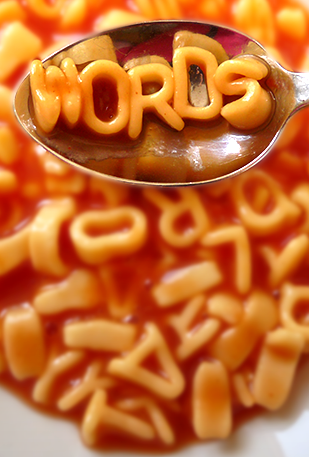

In [9]:
fdistl= FreqDist([w for w in most_frequent])

In [10]:
print(most_frequent, len(most_frequent))

{'james': 2648712, 'fort': 2167128, 'enron': 1444752, 'canada': 1444752, '200': 1203960, 'day': 240792, 'pm': 963168, 'subject': 963168, 'n': 963168, 'gas': 963168, 'kurt': 963168, 'anderson/ewc/enron': 963168, 'availability': 963168, 'friend': 722376, 'say': 722376, 'peace': 722376, 'year': 722376, '``': 722376, 'the': 722376, 'litigation': 722376, 'am': 722376, 'transact': 722376, 'ecc': 722376, 'corp.': 722376, 'following': 722376, "''": 722376, 'spreadsheet': 722376, 'dec': 722376, 'grid': 722376, 'data': 722376, 'words': 481584, 'your': 481584, 'would': 481584, 'wanted': 481584, 'work': 481584, 'every': 481584, 'time': 481584, 'happy': 481584, 'hope': 481584, 'agreed': 481584, 'master': 481584, 'left': 481584, 'b': 481584, 'ect': 481584, 'cyntia': 481584, 'may': 481584, 'continuing': 481584, 'relating': 481584, 'us': 481584, 'however': 481584, 'include': 481584, 'confirms': 481584, 'purposes': 481584, 'parent': 481584, 'company': 481584, 'received': 481584, 'indicating': 481584, '

One of the processes we will need to manage is part of speech tagging, or pos tagging.  This is just like grade school sentence diagrams but a little more complicated.   It consists of marking up a word in a text corpus as  a particular part of speech, based on  its definition and its context within the document.  NLTK makes this easy with the pos_tag method.  After that we will use the chunk method to find base syntactic constituents, such as base noun phrases. This outputs an NLTK tree.

We will start on Kay's emails again to see how it works.  Then if it does well we can move on to the whole dataset.

In [11]:
km_tag = nltk.pos_tag(useful_words)

In [12]:
start = datetime.now()

km_ne = nltk.ne_chunk(km_tag)

finish = datetime.now()
elapsed = finish-start

print("Time Elapsed: {}".format(elapsed))

Time Elapsed: 0:16:46.396567


In [13]:
type(km_ne)

nltk.tree.tree.Tree

Let's look at the top twenty chunks and see how they were tagged and chunked.  

In [14]:
km_ne[:20] 


[('array', 'NN'),
 ('``', '``'),
 ('Agreed', 'VBD'),
 ('I', 'PRP'),
 ("'m", 'VBP'),
 ('vacation', 'JJ'),
 ('week', 'NN'),
 ('high', 'JJ'),
 ('sierra', 'NN'),
 ("'s", 'POS'),
 ('unreachable', 'JJ'),
 ('\\nany', 'NN'),
 ('means', 'VBZ'),
 ('back', 'RP'),
 ('next', 'JJ'),
 ('monday', 'NN'),
 ('try', 'VB'),
 ('hook', 'NN'),
 ('next', 'JJ'),
 ('monday', 'NN')]

This looks like it worked.  PRP for 'I' is the right tag, I is a personal pronoun.  It would be easier if we had the list of tags handy.

__POS tag list:__
 - CC	coordinating conjunction
 - CD	cardinal digit
 - DT	determiner
 - EX	existential there (like: "there is" ... think of it like "there exists")
 - FW	foreign word
 - IN	preposition/subordinating conjunction
 - JJ	adjective	'big'
 - JJR	adjective, comparative	'bigger'
 - JJS	adjective, superlative	'biggest'
 - LS	list marker	1)
 - MD	modal	could, will
 - NN	noun, singular 'desk'
 - NNS	noun plural	'desks'
 - NNP	proper noun, singular	'Harrison'
 - NNPS	proper noun, plural	'Americans'
 - PDT	predeterminer	'all the kids'
 - POS	possessive ending	parent\'s
 - PRP	personal pronoun	I, he, she
 - PRP\$	possessive pronoun	my, his, hers
 - RB	adverb	very, silently,
 - RBR	adverb, comparative	better
 - RBS	adverb, superlative	best
 - RP	particle	give up
 - TO	to	go 'to' the store.
 - UH	interjection	errrrrrrrm
 - VB	verb, base form	take
 - VBD	verb, past tense	took
 - VBG	verb, gerund/present participle	taking
 - VBN	verb, past participle	taken
 - VBP	verb, sing. present, non-3d	take
 - VBZ	verb, 3rd person sing. present	takes
 - WDT	wh-determiner	which
 - WP	wh-pronoun	who, what
 - WP\$	possessive wh-pronoun	whose
 - WRB	wh-abverb	where, when


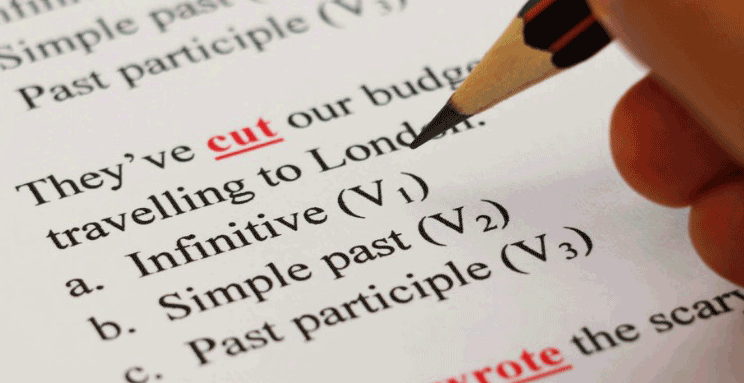

To get the named entities into a list we will have to traverse the tree object we created.  

In [15]:
test = []

In [16]:
#traversing the Nltk.tree.Tree object to get the list of parts of speech

begin = datetime.now()
for sent in nltk.sent_tokenize(str(km_text)):
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
        if hasattr(chunk, 'label'):
            test.append((chunk.label(),(c[0] for c in chunk)))
            
end = datetime.now()
print("\n\nTime Elapsed: {}".format(end-begin))



Time Elapsed: 0:44:19.478198


In [17]:
test[:10]

[('GPE', <generator object <genexpr> at 0x0000023865C15C80>),
 ('GPE', <generator object <genexpr> at 0x0000023865C15AC0>),
 ('PERSON', <generator object <genexpr> at 0x0000023865C15EB0>),
 ('ORGANIZATION', <generator object <genexpr> at 0x0000023865C15BA0>),
 ('ORGANIZATION', <generator object <genexpr> at 0x0000023865C15E40>),
 ('ORGANIZATION', <generator object <genexpr> at 0x0000023881E60E40>),
 ('ORGANIZATION', <generator object <genexpr> at 0x0000023881E60A50>),
 ('PERSON', <generator object <genexpr> at 0x0000023881E60C80>),
 ('PERSON', <generator object <genexpr> at 0x0000023881E60CF0>),
 ('PERSON', <generator object <genexpr> at 0x0000023881E60EB0>)]

That worked well, but we will need to work on that with the whole dataset.  Given how long our test set took, I recommend trying this over night.  


In [18]:
start = datetime.now()
print(start)
tagged = nltk.pos_tag(most_frequent)
chunked = nltk.ne_chunk(tagged)


2023-11-21 22:33:01.148052


Fabulous! It looks like that was a good run.  

Note that this takes a ton of processing power and if your computer does not have enough memory the kernel will die.  

Let's update the stop word list again.  After that we will run our functions again.  This is another doozy for your computer.  I added a number of checkpoints here to ensure we know it was still running smoothly.

In [19]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ["\\n", "--","I","''","Messege","\\t","-Added","-Original","-Deleted","To","1","No","''","\\","``","cc","-deleted",
        "From","...","Cc","``","'s","''","\\","``","+44","207","484","'", "5546","09","2001","53","'ve","'m","so.","\n"]
stopwords_list = [word.lower() for word in stopwords_list]


In [20]:
start = datetime.now()
print("Start Time\n",start)
text=[]
for mail in result.body:
    text.append(result.body.values)
print("\nChecking the length\n", len(text))

email=str(text)

print("\nChecking the type\n", type(email))

words_all= word_tokenize(email)

useful_all = [word.lower() for word in words_all if word not in stopwords_list]


print("\nChecking number of words\n", len(useful_all))
print("\nChecking words\n", useful_all[:25])

tagged = nltk.pos_tag(useful_all)
chunked = nltk.ne_chunk(tagged)

print("\nChecking tags\n", tagged[:25])

finish = datetime.now()

print("\nEnd Time\n",finish)

elapsed = finish-start
print("\nElaspsed time: {}.".format(elapsed))

Start Time
 2023-11-21 22:33:01.212129

Checking the length
 240792

Checking the type
 <class 'str'>

Checking number of words
 128582928

Checking words
 ['array', "'andrew", '-\\n\\nthanks', 'kind', 'words', 'friend', 'your', 'thoughtfulness', 'added', '\\nimmeasurable', 'joy', 'already', 'immeasurably', 'joyous', 'day', 'indeed', 'i', 'would', 'say', '\\nthat', 'greatest', 'day', 'my', 'life', 'except']

Checking tags
 [('array', 'NN'), ("'andrew", 'VBD'), ('-\\n\\nthanks', 'NNS'), ('kind', 'NN'), ('words', 'NNS'), ('friend', 'VBP'), ('your', 'PRP$'), ('thoughtfulness', 'NN'), ('added', 'VBD'), ('\\nimmeasurable', 'JJ'), ('joy', 'NN'), ('already', 'RB'), ('immeasurably', 'RB'), ('joyous', 'JJ'), ('day', 'NN'), ('indeed', 'RB'), ('i', 'NN'), ('would', 'MD'), ('say', 'VB'), ('\\nthat', 'WP'), ('greatest', 'JJS'), ('day', 'NN'), ('my', 'PRP$'), ('life', 'NN'), ('except', 'IN')]

End Time
 2023-11-22 05:40:35.400458

Elaspsed time: 7:07:34.188329.


In [21]:
chunked[:25]

[('array', 'NN'),
 ("'andrew", 'VBD'),
 ('-\\n\\nthanks', 'NNS'),
 ('kind', 'NN'),
 ('words', 'NNS'),
 ('friend', 'VBP'),
 ('your', 'PRP$'),
 ('thoughtfulness', 'NN'),
 ('added', 'VBD'),
 ('\\nimmeasurable', 'JJ'),
 ('joy', 'NN'),
 ('already', 'RB'),
 ('immeasurably', 'RB'),
 ('joyous', 'JJ'),
 ('day', 'NN'),
 ('indeed', 'RB'),
 ('i', 'NN'),
 ('would', 'MD'),
 ('say', 'VB'),
 ('\\nthat', 'WP'),
 ('greatest', 'JJS'),
 ('day', 'NN'),
 ('my', 'PRP$'),
 ('life', 'NN'),
 ('except', 'IN')]

Great it worked.  Now we have a list that should include named entities.  We can use the chunked data to look at a visualization of the frequency distribution.

In [22]:
fdist_all = FreqDist(chunked)
common_all = fdist_all.most_common(2000)

We will use matplot to create the cumulative distribution for the top 2,000 chunked/tagged words.

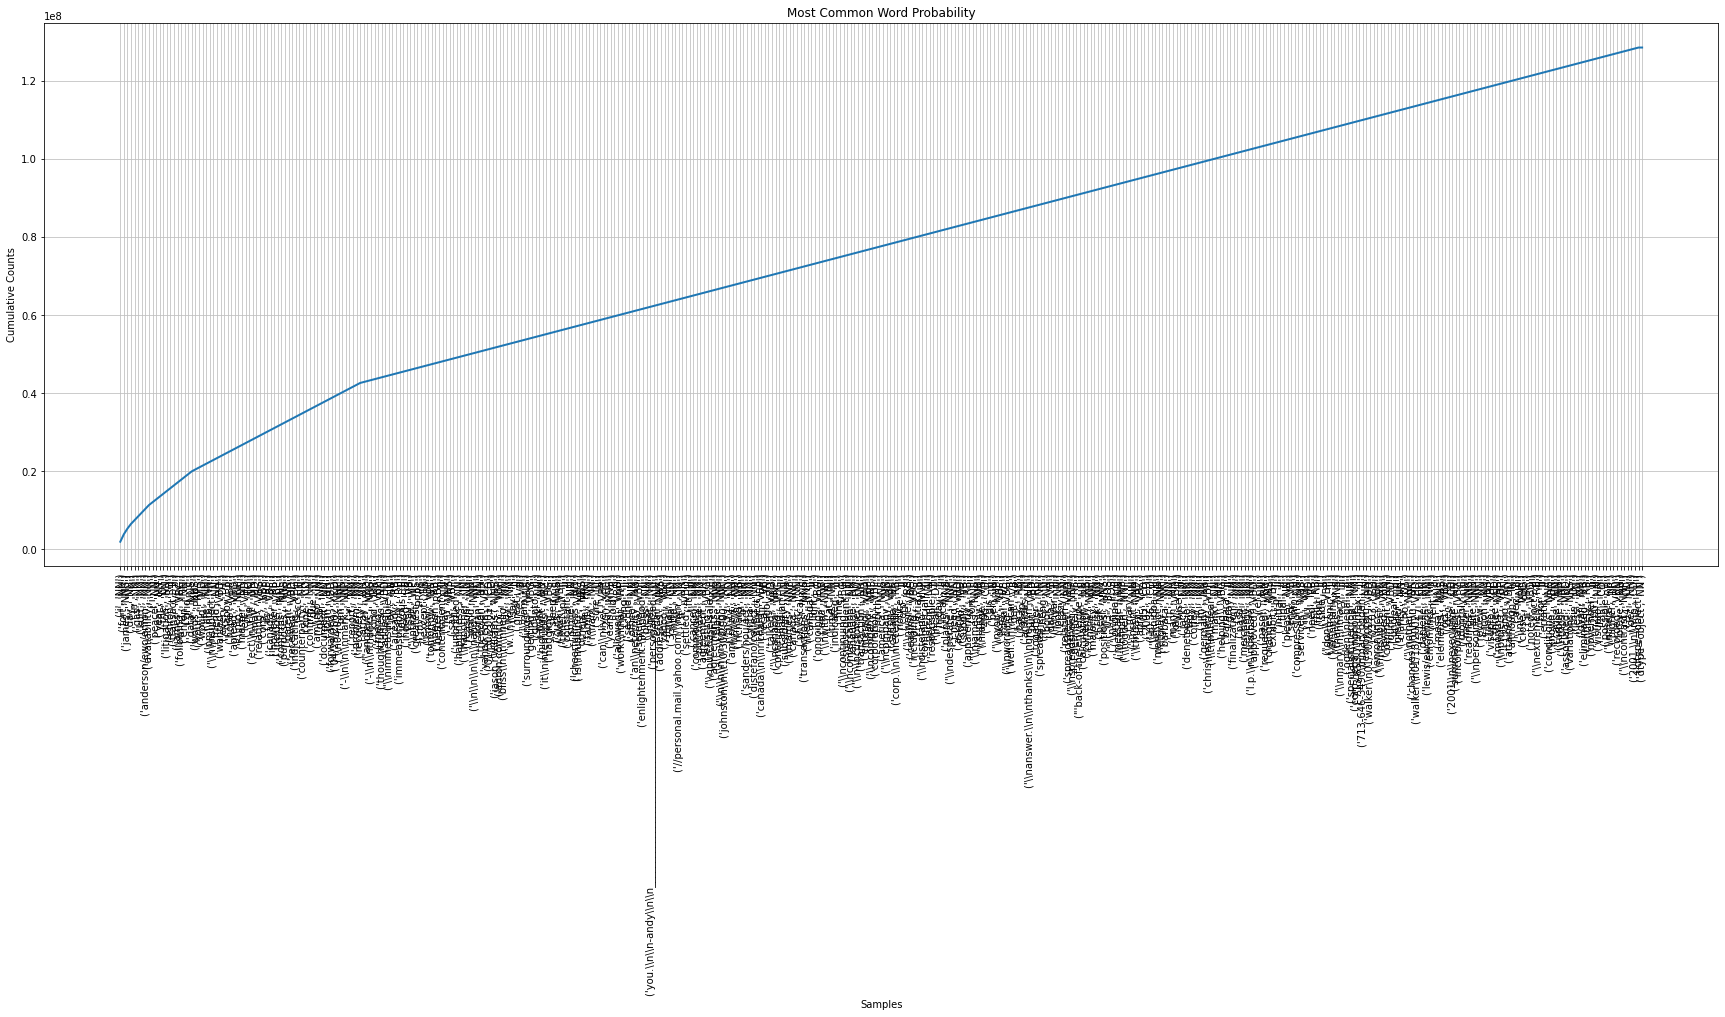

<Axes: title={'center': 'Most Common Word Probability'}, xlabel='Samples', ylabel='Cumulative Counts'>

In [23]:
plt.figure(figsize= (30,10))
fdist_all.plot(title="Most Common Word Probability",cumulative=True)


The visualization is great, but hte x-axis is a bit dense.  In this case we can look at a list easier and get the idea of where we would be on the curve.

This is the last section in our exploration,  we will start the machine learning in the next notebook.

In [24]:
common_words = [common_all[x][0][0] for x in range(0,len(common_all))]
common_words

['i',
 'fort',
 'james',
 'day',
 'in',
 'gas',
 'kurt',
 'anderson/ewc/enron',
 'availability',
 'i',
 'peace',
 'year',
 'the',
 'litigation',
 'enron',
 'transact',
 'james',
 'following',
 'enron',
 'grid',
 'data',
 'words',
 'your',
 'would',
 'life',
 'pm\\nto',
 '\\n\\nsubject',
 'friend',
 'wanted',
 'every',
 'happy',
 'hope',
 'agreed',
 '\\nto',
 'master',
 'left',
 'to',
 'ect\\n\\t\\t',
 'may',
 'relating',
 'corp.',
 'us',
 'canada',
 'however',
 'include',
 'confirms',
 'purposes',
 'parent',
 'received',
 'indicating',
 'ecc',
 'counterparty',
 'one',
 'confirm',
 'due',
 'am\\nto',
 'gisb',
 'document',
 'form',
 'forwarded',
 '04/29/2002',
 '\\n04:02',
 'pm',
 '-\\n\\n\\nmark',
 'v',
 'report',
 'problem',
 'recovery',
 'array',
 "'andrew",
 '-\\n\\nthanks',
 'kind',
 'friend',
 'thoughtfulness',
 'added',
 '\\nimmeasurable',
 'joy',
 'already',
 'immeasurably',
 'joyous',
 'indeed',
 'say',
 '\\nthat',
 'greatest',
 'my',
 'except',
 'know',
 'tomorrow',
 '\\neven',

### If you'd like to continue please move on to notebook, part 4.